## **Xây dựng câu hỏi và Phân tích dữ liệu**

### **Khai báo thư viện**

In [87]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

### **Đọc file CSV**

In [88]:
# Đọc dữ liệu
df = pd.read_csv('../data/raw/spotify_dataset.csv')

# Xem 5 dòng đầu tiên
display(df.head())

# Tổng quan kích thước
print(f"Số dòng: {df.shape[0]}")
print(f"Số cột: {df.shape[1]}")

# Kiểm tra kiểu dữ liệu và bộ nhớ
print("\nThông tin về kiểu dữ liệu")
df.info()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Số dòng: 114000
Số cột: 21

Thông tin về kiểu dữ liệu
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalne

### **Tiền xử lý dữ liệu**

Trước khi đi vào kiểm định giả thuyết, chúng tôi thực hiện quy trình tiền xử lý để đảm bảo dữ liệu sạch và phù hợp cho việc so sánh.

* **Làm sạch dữ liệu:**
    * **Hành động:** Loại bỏ các bài hát có **tempo = 0** và **duration_ms < 1000**.
    * **Lý do:** Như đã phân tích ở phần Khám phá dữ liệu (EDA), đây là các giá trị lỗi (hoặc là placeholder) hoặc file âm thanh hỏng, có thể gây nhiễu kết quả tính toán trung bình.

In [89]:
# Làm sạch dữ liệu
# Loại bỏ các bài hát lỗi (tempo = 0 hoặc duration quá ngắn)
df_clean = df[(df['tempo'] > 0) & (df['duration_ms'] >= 1000)].copy()

print(f"Số lượng bản ghi sau khi làm sạch: {df_clean.shape[0]}")
print(f"Đã loại bỏ: {df.shape[0] - df_clean.shape[0]} dòng lỗi.")

# Gán lại vào biến df chính để dùng cho phân tích
df = df_clean

Số lượng bản ghi sau khi làm sạch: 113842
Đã loại bỏ: 158 dòng lỗi.


### Câu hỏi 3: Liệu các bài hát viết ở giọng Trưởng (Major) có thực sự mang lại cảm giác tích cực và nhiều năng lượng hơn các bài giọng Thứ (Minor) như lý thuyết âm nhạc thường mặc định hay không?

#### Tại sao câu hỏi này đáng được nghiên cứu?

Trong lý thuyết âm nhạc truyền thống, giọng Trưởng (Major - Mode 1) thường được gắn liền với sự hạnh phúc, tươi sáng, trong khi giọng Thứ (Minor - Mode 0) đại diện cho sự buồn bã, u tối. Tuy nhiên, âm nhạc hiện đại rất phức tạp, liệu quy tắc này có còn đúng trên dữ liệu thực tế? Bên cạnh đó, việc xác định xem giọng Trưởng có thực sự tạo ra các bài hát **nhiều năng lượng** hơn hay không cũng là một khía cạnh quan trọng thường bị bỏ ngỏ.

#### Việc trả lời câu hỏi này sẽ mang lại lợi ích hoặc hiểu biết gì?

Việc kiểm chứng giả thuyết này giúp chúng ta hiểu rõ hơn về cách các đặc tính kỹ thuật (**mode**) ảnh hưởng đồng thời đến hai khía cạnh tâm lý của người nghe: mức độ tích cực (**valence**) và cường độ kích thích (**energy**).

#### Ai sẽ quan tâm đến câu trả lời?

Các nhà sản xuất âm nhạc, nhạc sĩ, chuyên gia phối khí và các nhà nghiên cứu tâm lý học âm nhạc.

#### Câu trả lời này giúp giải quyết vấn đề hoặc quyết định thực tế nào?

1.  **Hỗ trợ Nhạc sĩ và Nhà sản xuất âm nhạc:**
    * **Vấn đề:** Nhiều nhạc sĩ thường mặc định tư duy rằng *muốn bài hát vui và sung sức thì phải viết giọng Trưởng, muốn buồn và sâu lắng thì viết giọng Thứ*.
    * **Quyết định thực tế:** Kết quả phân tích giúp họ **thay đổi chiến lược sáng tác và phối khí**. Họ sẽ hiểu rằng một bài hát giọng Thứ hoàn toàn có thể mang năng lượng bùng nổ nếu biết cách phối hợp nhịp điệu (**tempo**) và cường độ (**loudness**), thay vì bị gò bó trong việc chọn Điệu thức (**mode**).

2.  **Cải thiện Hệ thống Gợi ý bài hát:**
    * **Vấn đề:** Các thuật toán gợi ý nhạc dễ mắc sai lầm nếu đánh đồng giọng Thứ với nhạc buồn/nhẹ nhàng. Ví dụ: Gợi ý một bản nhạc House sôi động (nhưng viết ở giọng Thứ) vào playlist **Nhạc thư giãn/Buồn** là một trải nghiệm người dùng tồi tệ.
    * **Quyết định thực tế:** Các kỹ sư dữ liệu không nên sử dụng **mode** làm đặc trưng duy nhất để phân loại tâm trạng. Họ cần kết hợp **mode** với **energy** để phân tách rõ ràng giữa nhạc **Buồn - Trầm lắng** và nhạc **Tối - Sôi động** trong thuật toán **Auto-tagging**.

#### Phân tích và Trực quan hóa

**Phương pháp phân tích**

Để trả lời câu hỏi *Giọng Trưởng có vui và nhiều năng lượng hơn giọng Thứ không?*, chúng tôi sử dụng phương pháp so sánh nhóm kết hợp với **Kiểm định thống kê**. Cụ thể:

* **Chọn đặc trưng:**
    * Để tập trung nguồn lực tính toán vào câu hỏi nghiên cứu, loại bỏ các yếu tố gây xao nhãng không liên quan nên ta chỉ tập trung vào 3 biến số: **mode** (biến phân loại), **valence** và **energy** (biến số).

* **Phân nhóm dữ liệu:**
    * Tách tập dữ liệu thành 2 nhóm độc lập dựa trên cột **mode**:
        * **Nhóm Major (1):** Đại diện cho giọng Trưởng.
        * **Nhóm Minor (0):** Đại diện cho giọng Thứ.

* **Trực quan hóa:**
    * **Sử dụng:** **Boxplot** và **KDE Plot**.
    * **Lý do:** Boxplot giúp so sánh nhanh trung vị và sự phân tán của dữ liệu, trong khi KDE giúp quan sát hình dáng phân phối (xem hai nhóm có bị chồng lấp lên nhau hay tách biệt hoàn toàn).

* **Kiểm định thống kê:**
    * **Sử dụng:** Kiểm định T-test cho hai mẫu độc lập.
    * **Lý do:** **valence** và **energy** là các biến liên tục, còn **mode** là biến phân loại nhị phân. T-test là công cụ tiêu chuẩn để xác định xem sự khác biệt giữa giá trị trung bình của hai nhóm này có ý nghĩa thống kê hay chỉ là ngẫu nhiên.

* **Kết quả đầu ra:**
    * **Biểu đồ so sánh:** Trực quan hóa sự khác biệt về độ cao cột và độ lệch của hai nhóm.
    * **Các chỉ số thống kê:** Giá trị trung bình của từng nhóm.
    * **Kết luận kiểm định:** Giá trị **P-value**.
        * Nếu $P < 0.05$: Khẳng định sự khác biệt là có thật (có ý nghĩa thống kê).
        * Nếu $P \ge 0.05$: Sự khác biệt không đáng kể.

Kết quả kiểm định T-test

Đặc trưng: valence
- Trung bình Major: 0.4791
- Trung bình Minor: 0.4671
- Chênh lệch: 0.0120
- P-value: 4.878833197646916e-14
-> Kết luận: Có sự khác biệt ý nghĩa thống kê

Đặc trưng: energy
- Trung bình Major: 0.6273
- Trung bình Minor: 0.6681
- Chênh lệch: 0.0408
- P-value: 5.3323423522537096e-160
-> Kết luận: Có sự khác biệt ý nghĩa thống kê


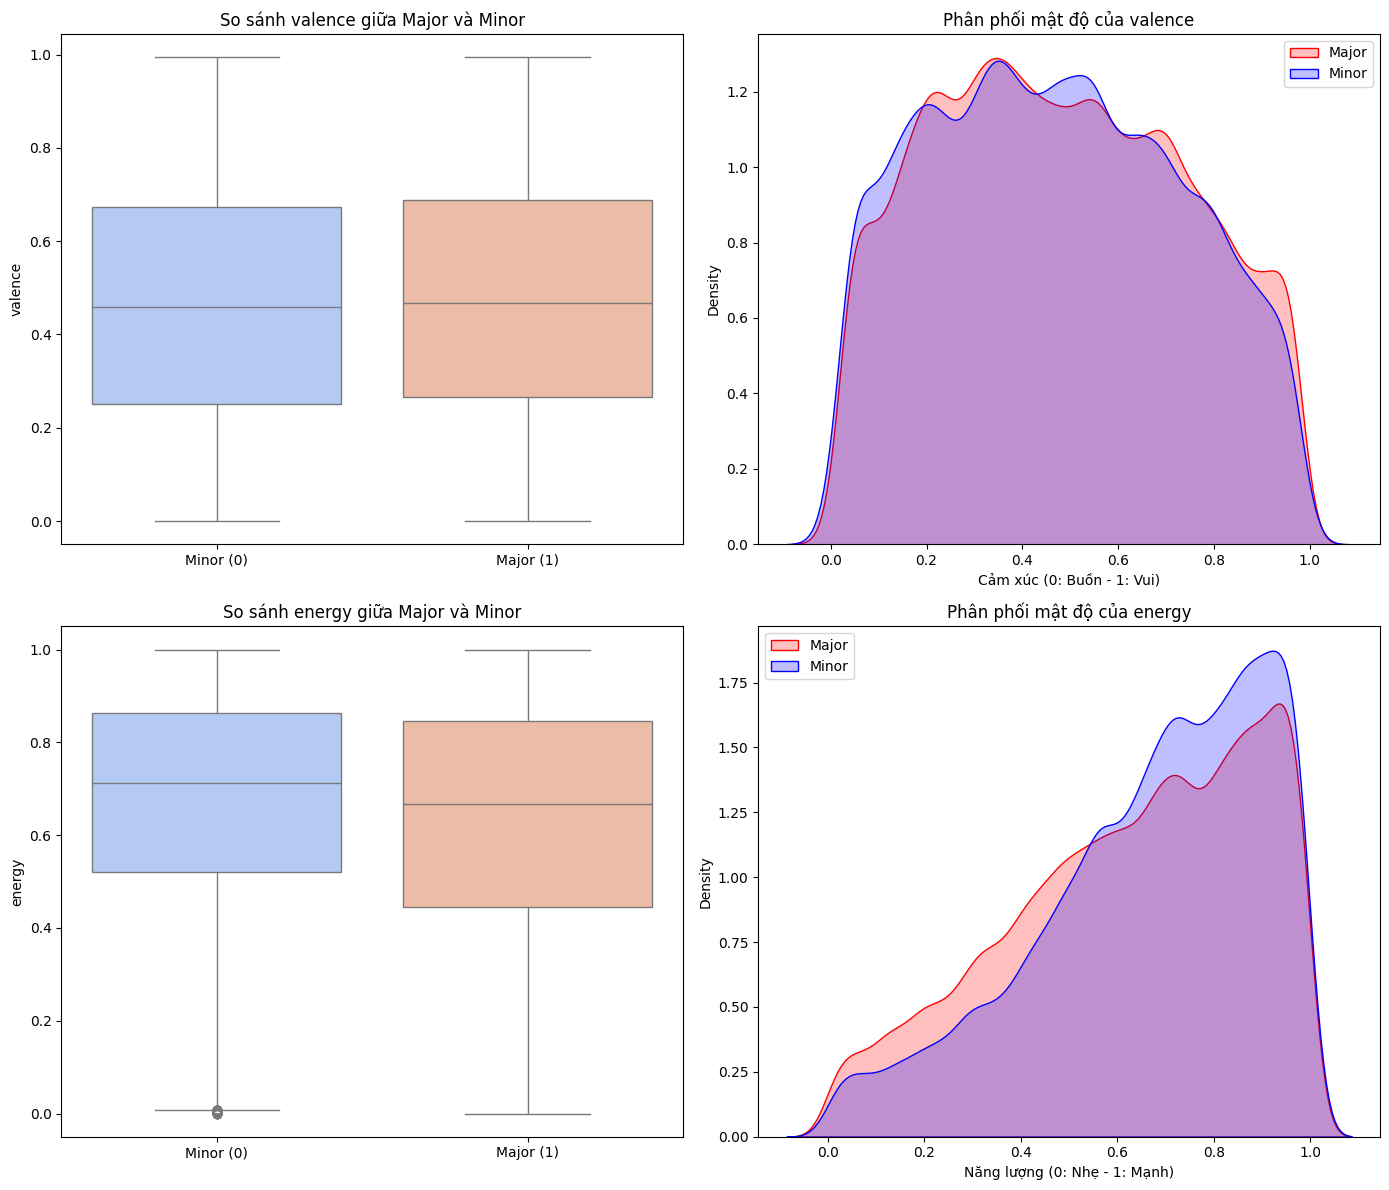

In [90]:
# Danh sách các đặc trưng muốn kiểm định
features_to_test = ['valence', 'energy']
labels = {
    'valence': 'Cảm xúc (0: Buồn - 1: Vui)',
    'energy': 'Năng lượng (0: Nhẹ - 1: Mạnh)'
}

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

print("Kết quả kiểm định T-test")

for i, feature in enumerate(features_to_test):
    # Tách nhóm dữ liệu
    major_data = df[df['mode'] == 1][feature]
    minor_data = df[df['mode'] == 0][feature]
    
    # Vẽ Boxplot
    sns.boxplot(x='mode', y=feature, data=df, ax=axes[i, 0], hue='mode', palette='coolwarm', legend=False)
    axes[i, 0].set_title(f'So sánh {feature} giữa Major và Minor')
    axes[i, 0].set_xticks([0, 1])
    axes[i, 0].set_xticklabels(['Minor (0)', 'Major (1)'])
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(feature)

    # Vẽ KDE plot
    sns.kdeplot(major_data, label='Major', fill=True, color='red', ax=axes[i, 1])
    sns.kdeplot(minor_data, label='Minor', fill=True, color='blue', ax=axes[i, 1])
    axes[i, 1].set_title(f'Phân phối mật độ của {feature}')
    axes[i, 1].set_xlabel(labels[feature])
    axes[i, 1].legend()

    # Kiểm định T-test và In kết quả
    t_stat, p_val = stats.ttest_ind(major_data, minor_data, equal_var=False)
    
    print(f"\nĐặc trưng: {feature}")
    print(f"- Trung bình Major: {major_data.mean():.4f}")
    print(f"- Trung bình Minor: {minor_data.mean():.4f}")
    print(f"- Chênh lệch: {abs(major_data.mean() - minor_data.mean()):.4f}")
    print(f"- P-value: {p_val}")
    
    if p_val < 0.05:
        print("-> Kết luận: Có sự khác biệt ý nghĩa thống kê")
    else:
        print("-> Kết luận: Không có sự khác biệt đáng kể")

plt.tight_layout()
plt.show()

**Kết luận**

1. **Về độ tích cực (valence):** Kết quả đúng với lý thuyết nhưng chênh lệch không lớn.
    * **Kết quả:** Nhóm bài hát giọng Trưởng (Major) có chỉ số **valence** trung bình cao hơn nhóm giọng Thứ (Minor) (0.479 so với 0.467). Sự khác biệt này có ý nghĩa thống kê (P-value $\approx 0$).
    * **Nhận định:** Mặc dù giọng Trưởng thực sự mang lại cảm giác tích cực hơn, nhưng mức chênh lệch rất nhỏ (chỉ khoảng 0.012). Điều này cho thấy trong âm nhạc hiện đại, **mode** không còn là yếu tố duy nhất quyết định bài hát đó "vui" hay "buồn". Một bài hát giọng Trưởng vẫn có thể rất buồn (ví dụ: Ballad chậm) và ngược lại.

2. **Về năng lượng (energy):** Kết quả trái ngược hoàn toàn với giả thuyết.
    * **Kết quả:** Nhóm bài hát giọng Thứ (Minor) lại có chỉ số **energy** trung bình **cao hơn** nhóm giọng Trưởng (0.668 so với 0.627). P-value rất nhỏ cho thấy sự khác biệt này là vô cùng rõ rệt.
    * **Nhận định:** Đây là một phát hiện thú vị và phản trực giác. Truyền thống cho rằng giọng Thứ là "buồn và u tối", nhưng dữ liệu cho thấy giọng Thứ được sử dụng rất nhiều trong các thể loại nhạc có cường độ mạnh, kích thích cao (như EDM, Techno, Trap, Hard Rock). Sự "u tối" của giọng Thứ khi kết hợp với nhịp độ nhanh và âm thanh lớn tạo ra sự **bùng nổ năng lượng** mạnh hơn cả giọng Trưởng.

3. **Đề xuất thực tế:**
    * **Cho các thuật toán gợi ý nhạc:** Không nên đơn giản gán nhãn "nhạc buồn" cho tất cả các bài hát có **mode = 0** (Minor). Cần kết hợp trọng số của **energy** và **tempo** để phân loại chính xác hơn.
    * **Cho nhà sản xuất âm nhạc:** Nếu muốn tạo ra một bản hit bùng nổ, đừng ngần ngại sử dụng giọng Thứ. Nó giúp bài hát vừa có chiều sâu cảm xúc, vừa duy trì được mức năng lượng cao mà khán giả hiện đại ưa chuộng.

### Câu hỏi 4: Sự khác biệt về đặc tính âm thanh giữa nhạc dán nhãn **explicit** và **non-explicit** là gì? Có phải nhạc **explicit** thường ồn ào (**loudness** cao), nhiều lời (**speechiness** cao) và khó nhảy (**danceability** thấp) hơn không?

#### Tại sao câu hỏi này đáng được nghiên cứu?

Nhãn **explicit** (nhạy cảm) thường được gán cho các bài hát có từ ngữ thô tục, bạo lực hoặc chủ đề nhạy cảm. Có một định kiến cho rằng nhạc **explicit** thường là Rap/Hip-hop hoặc Metal, do đó chúng sẽ rất ồn ào (**loudness** cao), nhiều lời (**speechiness** cao) và có thể khó nhảy" (**danceability** thấp) hơn nhạc Pop đại chúng. Việc kiểm chứng định kiến này giúp chúng ta hiểu rõ hồ sơ âm thanh (sonic profile) của nhóm nhạc này.

#### Việc trả lời câu hỏi này sẽ mang lại lợi ích hoặc hiểu biết gì?

Giúp xác định xem sự khác biệt giữa nhạc sạch (**non-explicit**) và nhạc nhạy cảm (**explicit**) chỉ nằm ở lời bài hát hay thực sự có sự khác biệt căn bản về cấu trúc âm thanh.

#### Ai sẽ quan tâm đến câu trả lời?

Các nền tảng Streaming (Spotify, Apple Music) để cải thiện tính năng **Safe Mode**, các nhà quảng cáo và các bậc phụ huynh.

#### Câu trả lời này giúp giải quyết vấn đề hoặc quyết định thực tế nào?

1. **Tối ưu hóa thuật toán gợi ý**:
    * **Vấn đề:** Nếu một người dùng thích nhạc êm dịu, liệu thuật toán có nên loại bỏ hết nhạc **explicit** không?
    * **Quyết định:** Nếu kết quả cho thấy nhạc **explicit** cũng có độ ồn thấp và giai điệu êm ái (ví dụ: R&B explicit), thuật toán vẫn có thể gợi ý chúng cho người lớn thay vì lọc bỏ hoàn toàn.

2. **Hỗ trợ chạy quảng cáo:**
    * Các thương hiệu hướng tới sự năng động, nổi loạn có thể nhắm mục tiêu vào các playlist có chỉ số **speechiness** và **loudness** cao (thường tương quan với explicit) để tiếp cận đúng tệp khách hàng trẻ.

#### Phân tích và Trực quan hóa

**Phương pháp phân tích**

Để trả lời câu hỏi: *Sự khác biệt về đặc tính âm thanh giữa nhạc Explicit và Non-explicit là gì?* và kiểm chứng các định kiến về độ ồn, lời bài hát hay khả năng nhảy, ta tiếp tục sử dụng phương pháp so sánh nhóm kết hợp **Kiểm định thống kê**. Cụ thể:

* **Chọn đặc trưng:**
    * Để tập trung vào các khía cạnh được nêu trong giả thuyết, chúng tôi chỉ trích xuất 4 biến số quan trọng:
        * **explicit** (Biến phân loại): Dùng để chia nhóm.
        * **loudness** (Biến số): Đại diện cho độ ồn hay cường độ âm thanh.
        * **speechiness** (Biến số): Đại diện cho mức độ nhiều lời.
        * **danceability** (Biến số): Đại diện cho độ dễ nhảy.

* **Phân nhóm dữ liệu:**
    * Tách tập dữ liệu thành 2 nhóm độc lập dựa trên nhãn dán **explicit**:
        * **Nhóm Explicit (True):** Các bài hát có nhãn nhạy cảm/người lớn.
        * **Nhóm Non-explicit (False):** Các bài hát phổ thông, không chứa từ ngữ nhạy cảm.

* **Trực quan hóa:**
    * **Sử dụng:** **Boxplot** và **KDE Plot**.
    * **Lý do:** Boxplot giúp so sánh nhanh trung vị và sự phân tán của dữ liệu, trong khi KDE giúp quan sát hình dáng phân phối (xem hai nhóm có bị chồng lấp lên nhau hay tách biệt hoàn toàn).

* **Kiểm định thống kê:**
    * **Sử dụng:** Kiểm định **T-test** cho hai mẫu độc lập.
    * **Lý do:** Các biến cần so sánh (**loudness, speechiness, danceability**) đều là biến số, trong khi biến chia nhóm (**explicit**) là nhị phân. T-test là công cụ tiêu chuẩn và mạnh mẽ nhất để kết luận sự khác biệt giữa hai nhóm này có ý nghĩa thống kê hay chỉ là ngẫu nhiên.
    * **Quy tắc ra quyết định:** Dựa vào giá trị **P-value**:
        * Nếu $P < 0.05$: Sự khác biệt giữa nhạc Explicit và Non-explicit là có thật và có ý nghĩa thống kê.
        * Nếu $P \ge 0.05$: Không đủ bằng chứng để khẳng định sự khác biệt.

Kết quả kiểm định thống kê T-test

Đặc trưng: loudness
- Trung bình Explicit    : -6.4729
- Trung bình Non-Explicit: -8.4053
- Chênh lệch (Mean Diff) : 1.9324
- P-value                : 0.0
-> Kết luận: Có sự khác biệt có ý nghĩa thống kê.

Đặc trưng: speechiness
- Trung bình Explicit    : 0.1911
- Trung bình Non-Explicit: 0.0748
- Chênh lệch (Mean Diff) : 0.1163
- P-value                : 0.0
-> Kết luận: Có sự khác biệt có ý nghĩa thống kê.

Đặc trưng: danceability
- Trung bình Explicit    : 0.6363
- Trung bình Non-Explicit: 0.5611
- Chênh lệch (Mean Diff) : 0.0752
- P-value                : 0.0
-> Kết luận: Có sự khác biệt có ý nghĩa thống kê.


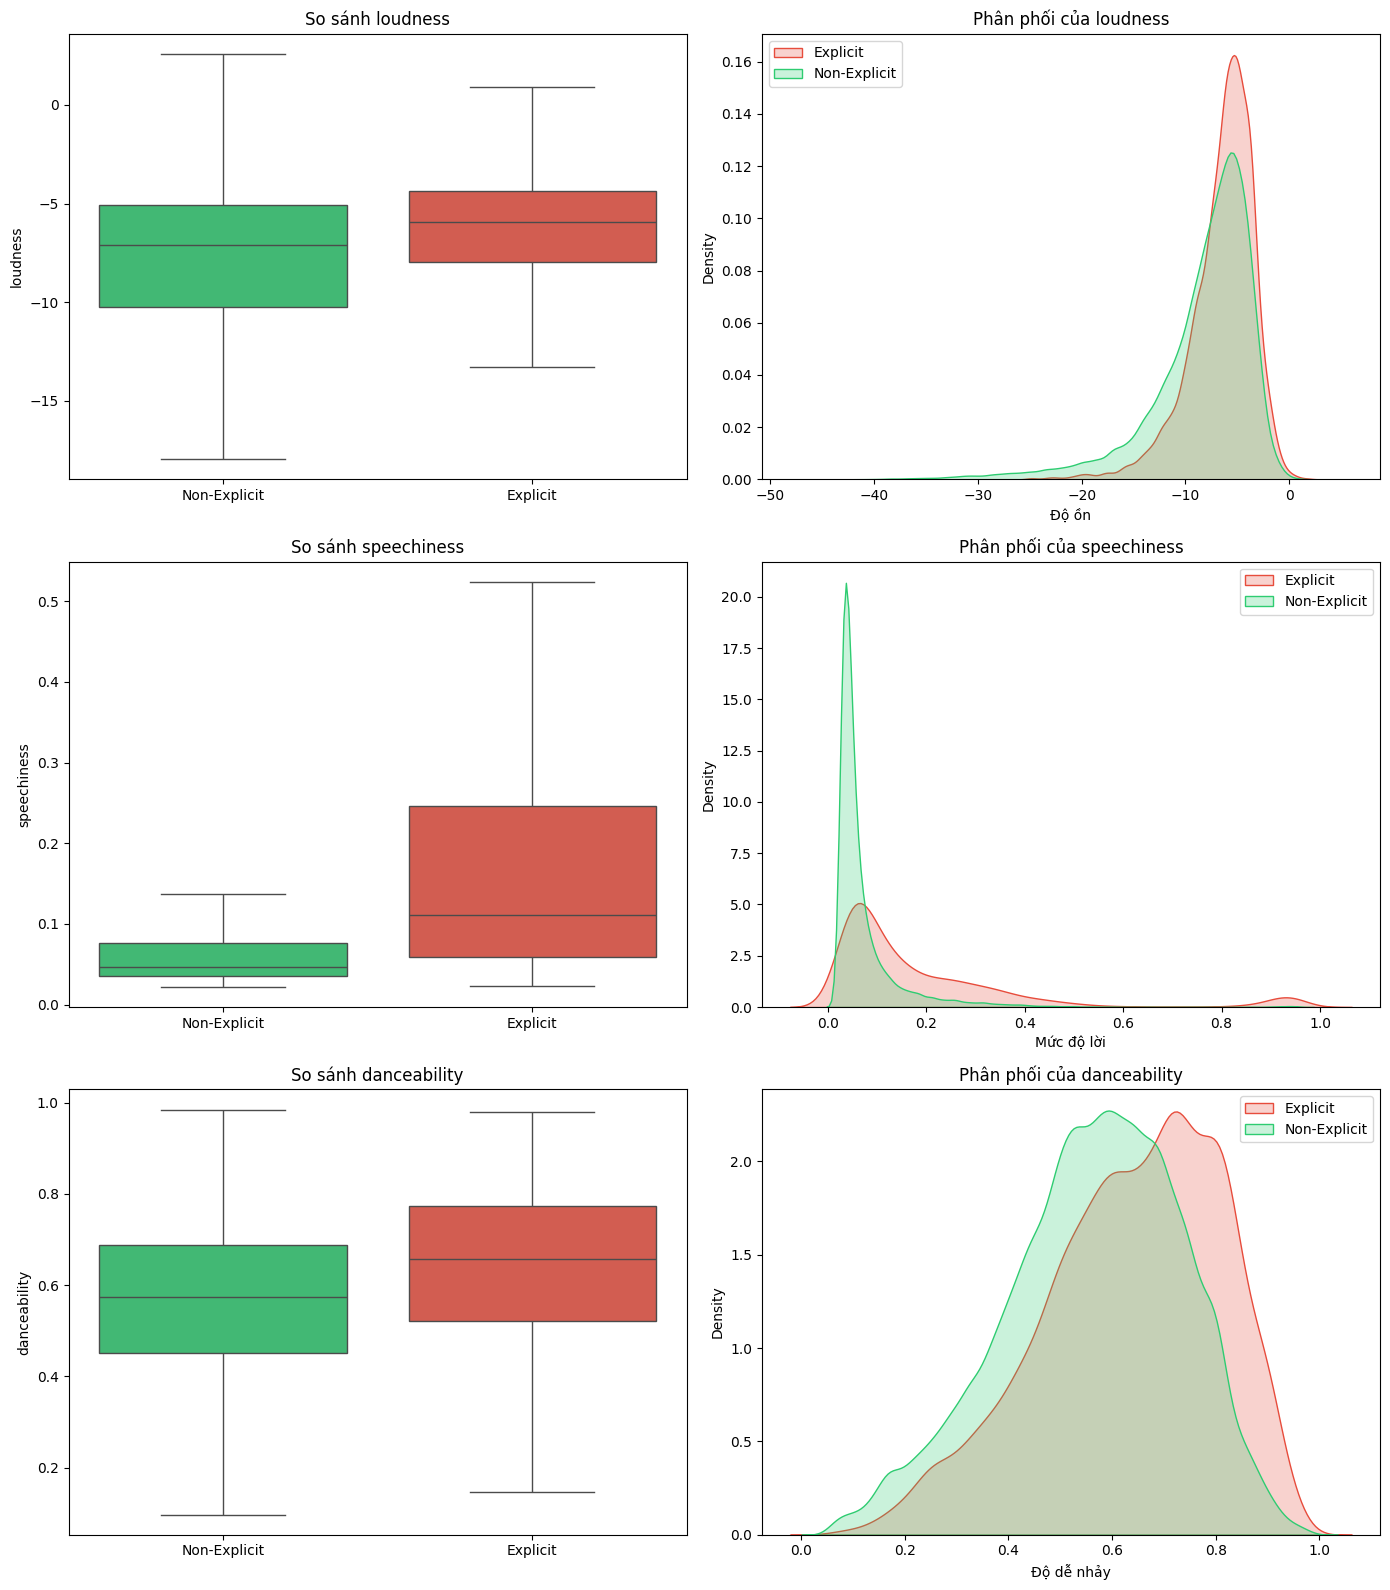

In [91]:
# Danh sách các đặc trưng cần kiểm định cho Câu hỏi 4
features_q4 = ['loudness', 'speechiness', 'danceability']

# Định nghĩa nhãn
labels_q4 = {
    'loudness': 'Độ ồn',
    'speechiness': 'Mức độ lời',
    'danceability': 'Độ dễ nhảy'
}

# Tạo khung vẽ biểu đồ
fig, axes = plt.subplots(3, 2, figsize=(14, 16))

print("Kết quả kiểm định thống kê T-test")

for i, feature in enumerate(features_q4):
    explicit_data = df[df['explicit'] == True][feature]
    non_explicit_data = df[df['explicit'] == False][feature]
    
    # Vẽ Boxplot
    sns.boxplot(x='explicit', y=feature, data=df, ax=axes[i, 0], 
                hue='explicit', legend=False,
                palette=["#2ecc71", "#e74c3c"],
                showfliers=False)  # <--- Dòng lệnh giúp biểu đồ sạch hơn
    
    axes[i, 0].set_title(f'So sánh {feature}')
    axes[i, 0].set_xticks([0, 1]) 
    axes[i, 0].set_xticklabels(['Non-Explicit', 'Explicit'])
    axes[i, 0].set_xlabel('')
    axes[i, 0].set_ylabel(feature)

    # Vẽ KDE Plot
    sns.kdeplot(explicit_data, label='Explicit', fill=True, color='#e74c3c', ax=axes[i, 1])
    sns.kdeplot(non_explicit_data, label='Non-Explicit', fill=True, color='#2ecc71', ax=axes[i, 1])
    axes[i, 1].set_title(f'Phân phối của {feature}')
    axes[i, 1].set_xlabel(labels_q4[feature])
    axes[i, 1].legend()

    # Tính toán T-test
    t_stat, p_val = stats.ttest_ind(explicit_data, non_explicit_data, equal_var=False, nan_policy='omit')
    
    # In kết quả
    print(f"\nĐặc trưng: {feature}")
    print(f"- Trung bình Explicit    : {explicit_data.mean():.4f}")
    print(f"- Trung bình Non-Explicit: {non_explicit_data.mean():.4f}")
    diff = abs(explicit_data.mean() - non_explicit_data.mean())
    print(f"- Chênh lệch (Mean Diff) : {diff:.4f}")
    print(f"- P-value                : {p_val}")
    
    if p_val < 0.05:
        print("-> Kết luận: Có sự khác biệt có ý nghĩa thống kê.")
    else:
        print("-> Kết luận: Không có sự khác biệt đáng kể.")

plt.tight_layout()
plt.show()

**Kết luận**

Dựa trên kết quả phân tích thống kê T-test và trực quan hóa dữ liệu trên 114,000 bài hát, chúng ta có thể đưa ra câu trả lời cho câu hỏi: *Sự khác biệt thực sự giữa nhạc explicit (nhạy cảm) và non-explicit (không nhạy cảm) là gì?*

1. **Về Độ ồn (loudness):** Nhạc **explicit** thực sự ồn ào hơn.
  * **Kết quả:** Nhạc **explicit** có độ ồn trung bình là **-6.47 dB**, lớn hơn đáng kể so với **-8.41 dB** của nhạc **non-explicit**.
  * **Nhận định:** Chênh lệch gần **2 dB** trong âm thanh là một khoảng cách rất lớn (cứ tăng 3dB là công suất âm thanh tăng gấp đôi). Điều này xác nhận giả thuyết rằng nhạc **explicit** thường đi kèm với cường độ âm thanh lớn, năng lượng mạnh (như trong các thể loại Hip-hop, Trap, Hard Rock).

2. **Về Mức độ lời (speechiness):** Sự khác biệt rõ rệt nhất.
  * **Kết quả:** Đây là nơi có sự phân hóa mạnh mẽ nhất. Nhạc **explicit** có chỉ số **speechiness** trung bình là **0.191**, cao gấp **2.5 lần** so với nhạc thường (**0.075**).
  * **Nhận định:** Kết quả này phản ánh đúng thực tế: Nhạc dán nhãn **explicit** phần lớn là nhạc Rap/Hip-hop, nơi mà lời bài hát với mật độ từ ngữ dày đặc đóng vai trò chủ đạo. Trong khi đó, nhạc phổ thông thiên về giai điệu hơn là lời nói.

3. **Về Độ dễ nhảy (danceability):** Bác bỏ hoàn toàn định kiến khó nhảy.
  * **Kết quả:** Trái ngược với suy nghĩ rằng nhạc gắt thì khó nhảy, nhạc **explicit** lại có chỉ số **danceability** trung bình cao hơn (**0.636** so với **0.561**).
  * **Nhận định:** Nhạc **explicit** không hề khó nuốt. Ngược lại, nhờ có nhịp điệu mạnh và đều đặn (đặc trưng của Hip-hop/Trap), chúng kích thích vận động tốt hơn nhạc Pop thông thường. Đây chính là lý do các bài hát **explicit** thường xuyên thống trị các sàn nhảy và playlist tập gym.

4. **Tổng kết và ứng dụng:**
  * Nhạc **explicit** không chỉ khác biệt ở lời bài hát thô tục mà còn mang một **bản dạng âm thanh** (sonic signature) rất riêng: **to hơn, nhiều lời hơn và dễ nhảy hơn.**
  * **Đề xuất cho thuật toán:** Nếu người dùng thích nghe nhạc Rap (**explicit**), hệ thống gợi ý hoàn toàn có thể đề xuất thêm các bài nhạc **non-explicit** nhưng có **dB > 0.6** và **loudness > -7dB** (ví dụ: Electro Pop, House) vì chúng có cấu trúc âm thanh tương đồng, giúp mở rộng khẩu vị âm nhạc của người dùng mà không gây sốc.